In [1]:
pip install pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

font_name = mpl.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False 

print(f"Matplotlib 폰트 설정 완료: {font_name}")

Matplotlib 폰트 설정 완료: Malgun Gothic


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 로드 및 정리
# header=2로 설정하여 '날짜'와 '종가' 컬럼을 올바르게 로드합니다.
try:
    df = pd.read_csv('삼성전자_10-11월시세.csv', encoding='euc-kr', header=2, sep=',', skipinitialspace=True)
except UnicodeDecodeError:
    df = pd.read_csv('삼성전자_10-11월시세.csv', encoding='utf-8', header=2, sep=',', skipinitialspace=True)

# 컬럼 이름의 불필요한 공백 제거
df.columns = df.columns.str.strip()

# 2. 필요한 컬럼만 선택 및 데이터 정제
df = df[['날짜', '종가']].copy()

# '날짜'가 NaN인 행(불필요한 빈 행)을 제거
df = df.dropna(subset=['날짜']).reset_index(drop=True)

# '종가'의 쉼표(,)를 제거하고 실수형(float)으로 변환
df['종가'] = df['종가'].str.replace(',', '', regex=False).astype(float)

# 날짜 순으로 정렬
df = df.sort_values(by='날짜').reset_index(drop=True)

print("--- Cell 1 실행 결과: 정제된 데이터프레임 (df) ---")
print(df.head())

--- Cell 1 실행 결과: 정제된 데이터프레임 (df) ---
           날짜       종가
0  2025.10.01  86000.0
1  2025.10.02  89000.0
2  2025.10.10  94400.0
3  2025.10.13  93300.0
4  2025.10.14  91600.0


In [5]:
# 3. 데이터 정규화 (Min-Max Scaling)
data = df['종가'].values.reshape(-1, 1) # 2차원 배열로 변환
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("--- Cell 2 실행 결과: 정규화된 데이터 ---")
print(f"scaled_data shape: {scaled_data.shape}")
print(f"scaled_data (첫 5개): {scaled_data[:5].flatten()}")

--- Cell 2 실행 결과: 정규화된 데이터 ---
scaled_data shape: (33, 1)
scaled_data (첫 5개): [0.         0.11952191 0.33466135 0.29083665 0.22310757]


In [6]:
# 4. 시퀀스 데이터 생성 함수 정의 및 실행
def create_sequences(data, seq_len):
    """과거 seq_len 길이의 데이터(X)로 다음 1일의 데이터(Y)를 예측하는 시퀀스 생성"""
    X = []
    Y = []
    for i in range(len(data) - seq_len):
        # 과거 seq_len 일의 데이터 (X)
        X.append(data[i:(i + seq_len), 0])
        # 다음 날의 데이터 (Y, 예측 목표)
        Y.append(data[i + seq_len, 0])
    return np.array(X), np.array(Y)

SEQ_LEN = 10
X, Y = create_sequences(scaled_data, SEQ_LEN)

print("--- Cell 3 실행 결과: 시퀀스 데이터 크기 ---")
print(f"SEQ_LEN: {SEQ_LEN}")
print(f"X (전체 입력 시퀀스) shape: {X.shape}")
print(f"Y (전체 레이블) shape: {Y.shape}")

--- Cell 3 실행 결과: 시퀀스 데이터 크기 ---
SEQ_LEN: 10
X (전체 입력 시퀀스) shape: (23, 10)
Y (전체 레이블) shape: (23,)


In [7]:
# 5. 학습/테스트 데이터 분리 및 RNN 입력 형태 재구성
# 80%를 학습용, 20%를 테스트용으로 분리
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# RNN 입력 형태(3차원)로 재구성 (특징 수 = 1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("--- Cell 4 실행 결과: 최종 데이터셋 형태 ---")
print(f"X_train shape (학습 입력): {X_train.shape}")
print(f"Y_train shape (학습 레이블): {Y_train.shape}")
print(f"X_test shape (테스트 입력): {X_test.shape}")
print(f"Y_test shape (테스트 레이블): {Y_test.shape}")

--- Cell 4 실행 결과: 최종 데이터셋 형태 ---
X_train shape (학습 입력): (18, 10, 1)
Y_train shape (학습 레이블): (18,)
X_test shape (테스트 입력): (5, 10, 1)
Y_test shape (테스트 레이블): (5,)


In [8]:
# Cell 4.5: TensorFlow 즉시 실행 모드 최종 강제 활성화

import tensorflow as tf

print("--- TensorFlow 환경 설정 시작 ---")

# 1. 즉시 실행 모드를 강제 활성화 (NotImplementedError 해결)
# Keras 학습 안정성을 위해 run_functions_eagerly도 True로 설정
tf.config.run_functions_eagerly(True)

# 2. tf.data 디버그 모드 설정 (TypeError 해결을 위해 try-except 사용)
try:
    # 최신 버전을 위해 인자 없이 호출
    tf.data.experimental.enable_debug_mode()
except:
    # 예전 버전을 위해 인자 포함 호출 시도 (대부분의 경우 이것이 문제를 일으키는 원인)
    try:
        tf.data.experimental.enable_debug_mode(True)
    except:
        pass # 두 경우 모두 실패하면 무시

# 3. 명시적으로 즉시 실행 모드 확인
if tf.executing_eagerly():
    print("✅ 즉시 실행 모드(Eager Execution) 활성화 확인 완료.")
else:
    # 만약 여기에 도달하면 환경 문제이므로 커널 재시작을 권장합니다.
    print("⚠️ 즉시 실행 모드가 비활성화되어 있습니다. Jupyter 커널을 재시작하고 다시 시도하세요.")

print("--- 환경 설정 완료 ---")

--- TensorFlow 환경 설정 시작 ---
✅ 즉시 실행 모드(Eager Execution) 활성화 확인 완료.
--- 환경 설정 완료 ---


In [16]:
# Cell 5: 핵심 파라미터 설정

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam

# 전처리 Cell 3에서 정의된 시퀀스 길이 (SEQ_LEN=10) 사용
SEQ_LEN = 10 

# --- 핵심 하이퍼파라미터 설정 ---
EPOCHS = 50            # 학습 반복 횟수
BATCH_SIZE = 4         # 배치 크기
UNITS = 32             # RNN/LSTM/GRU 레이어의 뉴런(유닛) 수
INPUT_SHAPE = (SEQ_LEN, 1) # (시퀀스 길이, 특징 수) = (10, 1)
LEARNING_RATE = 0.001  # Adam Optimizer의 학습률
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = 'mse'           # Mean Squared Error, 회귀 문제에 사용

print(f"RNN 입력 형태 (INPUT_SHAPE): {INPUT_SHAPE}")
print(f"순환 레이어 유닛 수 (UNITS): {UNITS}")

RNN 입력 형태 (INPUT_SHAPE): (10, 1)
순환 레이어 유닛 수 (UNITS): 32


In [13]:
# RNN, LSTM, GRU 모델 정의 및 컴파일
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Input
from tensorflow.keras.optimizers import Adam

# 1. SimpleRNN 모델 정의
def build_rnn_model_fixed():
    model = Sequential([
        Input(shape=INPUT_SHAPE), # <--- Input 레이어 추가
        SimpleRNN(units=UNITS), 
        Dense(1) 
    ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    return model

# 2. LSTM 모델 정의
def build_lstm_model_fixed():
    model = Sequential([
        Input(shape=INPUT_SHAPE), # <--- Input 레이어 추가
        LSTM(units=UNITS),
        Dense(1)
    ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    return model

# 3. GRU 모델 정의
def build_gru_model_fixed():
    model = Sequential([
        Input(shape=INPUT_SHAPE), # <--- Input 레이어 추가
        GRU(units=UNITS),
        Dense(1)
    ])
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    return model

# 모델 생성
rnn_model = build_rnn_model_fixed()
lstm_model = build_lstm_model_fixed()
gru_model = build_gru_model_fixed()

print("--- 실행 완료: 모델 정의 및 컴파일 완료 ---")

# 이후 학습 단계에서 사용할 모델들을 딕셔너리에 저장
models = {
    "RNN": rnn_model,
    "LSTM": lstm_model,
    "GRU": gru_model
}

--- 실행 완료: 모델 정의 및 컴파일 완료 ---


In [24]:
# 모델 학습 및 결과 저장

import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K # 가중치 재설정

# 1. 모델 정의 함수
def create_model(model_type):
    """모델 유형에 따라 새로운 Keras 모델을 생성 및 컴파일하는 함수"""
    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    
    if model_type == "RNN":
        model = Sequential([Input(shape=INPUT_SHAPE), SimpleRNN(units=UNITS), Dense(1)])
    elif model_type == "LSTM":
        model = Sequential([Input(shape=INPUT_SHAPE), LSTM(units=UNITS), Dense(1)])
    elif model_type == "GRU":
        model = Sequential([Input(shape=INPUT_SHAPE), GRU(units=UNITS), Dense(1)])
    else:
        raise ValueError(f"Unknown model type: {model_type}")
        
    model.compile(optimizer=OPTIMIZER, loss=LOSS)
    return model

# 2. NumPy 배열을 tf.data.Dataset으로 변환
print("NumPy 배열을 tf.data.Dataset으로 변환 중...")
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


# 3. 학습 루프
results = {}

for name in MODELS_TO_RUN:
    model = create_model(name)
    
    # Keras/TensorFlow 환경 클리어
    K.clear_session()
    
    print(f"\n--- {name} 모델 학습 시작 ---")
    
    # 모델 학습
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        verbose=2 
    )
    
    # 예측 수행
    y_pred_scaled = model.predict(X_test)
    
    # 예측값과 실제 테스트 레이블을 원래 스케일로 복원
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1))
    
    # 성능 평가 (RMSE 계산)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
    
    print(f"\n{name} 모델 학습 완료. Test RMSE: {rmse:.2f} KRW")

    # 결과 기록
    results[name] = {
        'model': model,
        'history': history,
        'predictions': y_pred,
        'test_actual': y_test_original,
        'rmse': rmse
    }

NumPy 배열을 tf.data.Dataset으로 변환 중...

--- RNN 모델 학습 시작 ---
Epoch 1/50
5/5 - 0s - 64ms/step - loss: 0.2358 - val_loss: 0.0134
Epoch 2/50
5/5 - 0s - 54ms/step - loss: 0.0461 - val_loss: 0.1382
Epoch 3/50
5/5 - 0s - 54ms/step - loss: 0.0574 - val_loss: 0.0807
Epoch 4/50
5/5 - 0s - 53ms/step - loss: 0.0276 - val_loss: 0.0180
Epoch 5/50
5/5 - 0s - 58ms/step - loss: 0.0316 - val_loss: 0.0082
Epoch 6/50
5/5 - 0s - 57ms/step - loss: 0.0358 - val_loss: 0.0134
Epoch 7/50
5/5 - 0s - 53ms/step - loss: 0.0265 - val_loss: 0.0320
Epoch 8/50
5/5 - 0s - 52ms/step - loss: 0.0233 - val_loss: 0.0429
Epoch 9/50
5/5 - 0s - 56ms/step - loss: 0.0221 - val_loss: 0.0339
Epoch 10/50
5/5 - 0s - 61ms/step - loss: 0.0208 - val_loss: 0.0237
Epoch 11/50
5/5 - 0s - 59ms/step - loss: 0.0215 - val_loss: 0.0229
Epoch 12/50
5/5 - 0s - 62ms/step - loss: 0.0207 - val_loss: 0.0290
Epoch 13/50
5/5 - 0s - 56ms/step - loss: 0.0194 - val_loss: 0.0340
Epoch 14/50
5/5 - 0s - 54ms/step - loss: 0.0185 - val_loss: 0.0329
Epoch 15/50
5

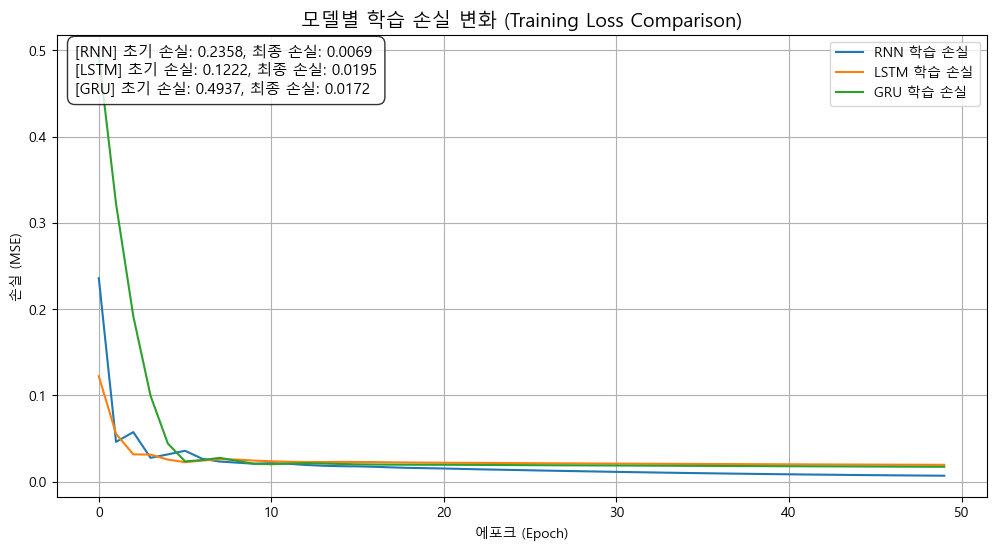

In [25]:
# 학습 손실 (LOSS율) 시각화

import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False 

fig_loss, ax_loss = plt.subplots(figsize=(12, 6))
ax_loss.set_title('모델별 학습 손실 변화 (Training Loss Comparison)', fontsize=14) 
ax_loss.set_xlabel('에포크 (Epoch)')
ax_loss.set_ylabel('손실 (MSE)')

# 손실 정보를 그래프 내에 표기하기 위한 리스트 초기화
loss_annotations = []

# 이전 results 변수 사용
for name in MODELS_TO_RUN:
    history = results[name]['history']
    
    # 1. LOSS 그래프
    ax_loss.plot(history.history['loss'], label=f'{name} 학습 손실', linestyle='-')
    
    # 2. 초기/최종 LOSS 값 추출
    initial_loss = history.history['loss'][0]
    final_loss = history.history['loss'][-1]
    
    # 3. 텍스트 정보 준비
    annotation_text = f"[{name}] 초기 손실: {initial_loss:.4f}, 최종 손실: {final_loss:.4f}"
    loss_annotations.append(annotation_text)

# 4. 최종 시각화 정리 및 손실 값
ax_loss.legend(loc='upper right')
ax_loss.grid(True)

# 초기/최종 손실 값
annotation_string = "\n".join(loss_annotations)
ax_loss.text(
    0.02, 0.98, annotation_string, 
    transform=ax_loss.transAxes, 
    fontsize=11, 
    verticalalignment='top', 
    bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8)
)

plt.show()

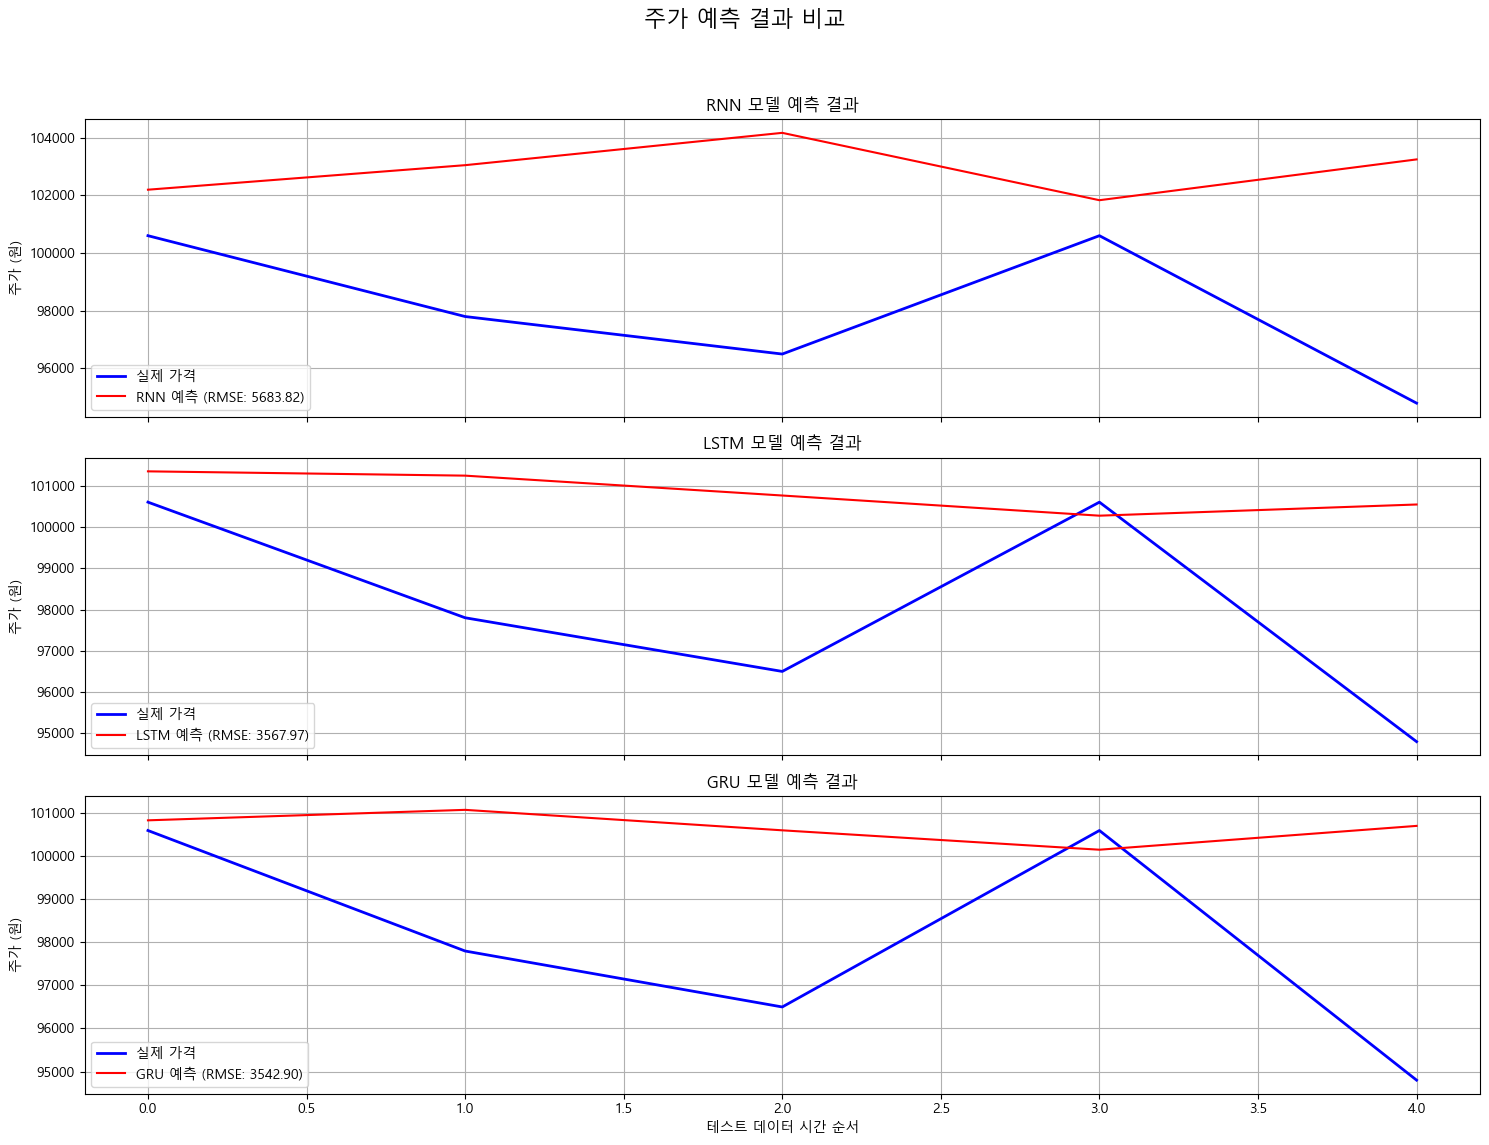

In [26]:
# 예측 결과 그래프 시각화

import matplotlib.pyplot as plt

fig_pred, axes_pred = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig_pred.suptitle('주가 예측 결과 비교', fontsize=16)

# 이전 정의된 Y_test_orig, test_indices, results 변수
for i, name in enumerate(MODELS_TO_RUN):
    res = results[name]
    
    # 예측 가격 (Prediction)
    y_pred = res['predictions']
    rmse = res['rmse']
    
    ax = axes_pred[i]
    
    # 1. 실제 가격 (Actual Price) - 실선
    ax.plot(test_indices, Y_test_orig, label='실제 가격', color='blue', linewidth=2)
    
    # 2. 예측 가격 (Prediction) - 실선
    ax.plot(test_indices, y_pred, label=f'{name} 예측 (RMSE: {rmse:.2f})', color='red', linestyle='-') 
    
    # 3. 그래프 제목 및 설정
    ax.set_title(f'{name} 모델 예측 결과')
    ax.set_ylabel('주가 (원)')
    ax.legend(loc='lower left')
    ax.grid(True)


axes_pred[-1].set_xlabel('테스트 데이터 시간 순서')
fig_pred.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 

In [29]:
# 다음 주가 예측

import numpy as np

# 1. 최적 모델 선택
BEST_MODEL_NAME = "GRU" # RMSE 값이 가장 낮은 모델
best_model = results[BEST_MODEL_NAME]['model'] 

# 2. 예측에 사용할 가장 최근 시퀀스 데이터 준비
SEQ_LEN = 10
last_10_days_scaled = scaled_data[-SEQ_LEN:]

# 3. 모델 입력 형태(3차원)로 재구성: (1, SEQ_LEN, 1)
last_sequence = last_10_days_scaled.reshape(1, SEQ_LEN, 1)

# 4. 예측 수행
predicted_price_scaled = best_model.predict(last_sequence)

# 5. 원래 주가 스케일로 역변환
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# 6. 결과 출력
print(f"--- {BEST_MODEL_NAME} 모델을 이용한 다음 날 주가 예측 ---")
print(f"입력 시퀀스 길이: {SEQ_LEN}일")
print(f"정규화된 예측 값: {predicted_price_scaled.flatten()[0]:.6f}")
print(f"최종 예측 주가 (원): {predicted_price.flatten()[0]:.2f} 원")

# 마지막으로 알려진 종가
last_known_price = df['종가'].iloc[-1]
print(f"마지막 거래일의 실제 종가: {last_known_price:.2f} 원")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
--- GRU 모델을 이용한 다음 날 주가 예측 ---
입력 시퀀스 길이: 10일
정규화된 예측 값: 0.550340
최종 예측 주가 (원): 99813.52 원
마지막 거래일의 실제 종가: 94800.00 원
